# This model will identify weather the given image is of a cat or a dog.

#### [Click here to goto the kaggle dataset which i used for this model](https://www.kaggle.com/datasets/tongpython/cat-and-dog)
The accuracy of this model came around 80% 

@author: SankalpSinghBais

# Downloading and defining dataset location

In [1]:
%config Completer.use_jedi = False    #this line is not necessary. Its for using autocomplete in kaggle notebook
import os
#if using kaggle then 
data_path = "../input/cat-and-dog/"
#else change the path above to the path of your data

In [2]:
##run this cell if you want to download the data from kaggle. generate the kaggle key before proceeding futher

# !pip install opendatasets
# import opendatasets as od
# dataset_url = "https://www.kaggle.com/datasets/tongpython/cat-and-dog"
# od.download(dataset_url)
# od.download("https://www.kaggle.com/datasets/sankalpsinghbais/catvsdogtest")
#data_path="./cat-and-dog/"

In [3]:
train_path = os.path.join(data_path, 'training_set/training_set')
test_path = os.path.join(data_path, 'test_set/test_set')

# Creating datagenerators

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd

In [5]:
#checking original dimension of the training image
img = train_path+'/cats/cat.1.jpg'
print(image.load_img(img).size)
img = train_path+'/cats/cat.2.jpg'
print(image.load_img(img).size)
img = train_path+'/dogs/dog.3.jpg'
print(image.load_img(img).size)
img = train_path+'/dogs/dog.4.jpg'
print(image.load_img(img).size)
img = train_path+'/dogs/dog.10.jpg'
print(image.load_img(img).size)

(300, 280)
(312, 396)
(499, 375)
(300, 287)
(269, 292)


In [6]:
#average image size of above 5 images is (336,327) which is pretty high so rescaling images as per below size
img_size = (128, 128)
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=40,
    width_shift_range=0.1,          
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest',
    validation_split=0.25)

train_data = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset = 'training')

val_data = train_datagen.flow_from_directory(
        train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode='binary',
        subset = 'validation')
    

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        class_mode='binary',
        batch_size=1)

Found 6004 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


# Creating Simple CNN Model

In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

Read about kernel initializers used below by [Clicking Here](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal)

In [8]:
cnn_Model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
	
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
	MaxPooling2D((2, 2)),
	
    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
	MaxPooling2D((2, 2)),
	
    Flatten(),
	
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    #Dropout(0.5),
    
    Dense(1, activation = 'sigmoid')
])

2022-05-25 14:37:52.143449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 14:37:52.247236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 14:37:52.247993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 14:37:52.249654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
cnn_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0

## Compiling and training the model with callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('cvd_cnn_model.h5',monitor = 'val_accuracy', verbose = 1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose = 1, mode = 'max')

callbacks_list = [checkpoint, earlystop]

In [11]:
cnn_Model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
history = cnn_Model.fit(train_data,steps_per_epoch=train_data.samples//batch_size, 
                                  validation_data=val_data, validation_steps=val_data.samples//batch_size,
                                  epochs=50, verbose=1, shuffle=True, callbacks=callbacks_list)

2022-05-25 14:37:56.248874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-25 14:37:59.144105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/46 [==============================] - 94s 2s/step - loss: 3.4170 - accuracy: 0.5097 - val_loss: 0.6985 - val_accuracy: 0.5036

Epoch 00001: val_accuracy improved from -inf to 0.50365, saving model to cvd_cnn_model.h5
Epoch 2/50
46/46 [==============================] - 53s 1s/step - loss: 0.6927 - accuracy: 0.5189 - val_loss: 0.6912 - val_accuracy: 0.5557

Epoch 00002: val_accuracy improved from 0.50365 to 0.55573, saving model to cvd_cnn_model.h5
Epoch 3/50
46/46 [==============================] - 52s 1s/step - loss: 0.6852 - accuracy: 0.5574 - val_loss: 0.6769 - val_accuracy: 0.5885

Epoch 00003: val_accuracy improved from 0.55573 to 0.58854, saving model to cvd_cnn_model.h5
Epoch 4/50
46/46 [==============================] - 52s 1s/step - loss: 0.6797 - accuracy: 0.5674 - val_loss: 0.6697 - val_accuracy: 0.5880

Epoch 00004: val_accuracy did not improve from 0.58854
Epoch 5/50
46/46 [==============================] - 51s 1s/step - loss: 0.6523 - accuracy: 0.6195 - val_loss: 0.6370

# Evaluating predicting and plotting accuracy

In [13]:
#defining a function for plotting accuracy and loss 
import matplotlib.pyplot as plt
def plot_acc_los(history):
#     print(history.history.keys())

    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

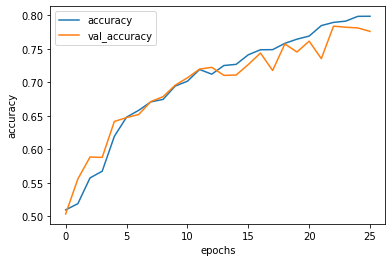

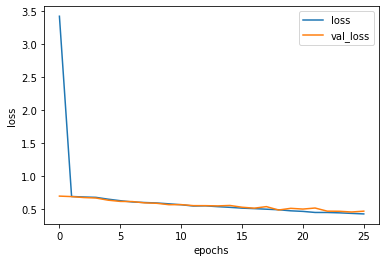

In [14]:
plot_acc_los(history)

In [15]:
#evaluating model accuracy and loss 
los, acc = cnn_Model.evaluate(test_data)
print("accuracy = ", acc*100, "%, Loss = ", los*100, "%")

2023/2023 [==============================] - 18s 9ms/step - loss: 0.4186 - accuracy: 0.8107
accuracy =  81.06772303581238 %, Loss =  41.85706377029419 %


In [16]:
#getting info about indices so that we can label it
print(train_data.class_indices)

{'cats': 0, 'dogs': 1}


In [17]:
#predicting Image
import numpy as np
from keras.preprocessing import image
def predict_image(model, img):
    '''pass the image location as input'''
    img = image.load_img(img, target_size = img_size)
    plt.imshow(img)
    plt.show()
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    pred = model.predict(img)
    print(f"Pred value = {pred}")
    
    if pred[0][0]>=1:
        result = 'This image has a DOG'
    else:
        result = 'This image has a CAT'
    return result

 ### To predict an image upload it to kaggle or notebook whatever you are using then pass the image path as an string to the predict image function defined above

In [18]:
def real_pred(model):
    #replace ../input with ./ if you are not using kaggle 
    test1 = "../input/catvsdogtest/cat_test.jpeg"
    test2 = "../input/catvsdogtest/dog_test.jpeg"
    print(predict_image(model, test1))
    print(predict_image(model, test2))

    test3 ="../input/cat-and-dog/test_set/test_set/cats/cat.4040.jpg"
    test4 = "../input/cat-and-dog/test_set/test_set/dogs/dog.4040.jpg"
    print(predict_image(model, test3))
    print(predict_image(model, test4))


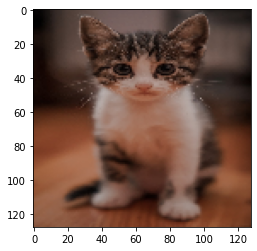

Pred value = [[6.800281e-33]]
This image has a CAT


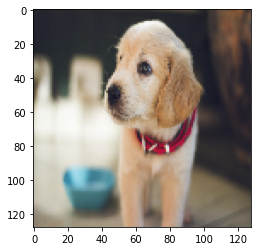

Pred value = [[1.]]
This image has a DOG


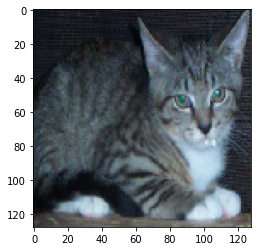

Pred value = [[0.]]
This image has a CAT


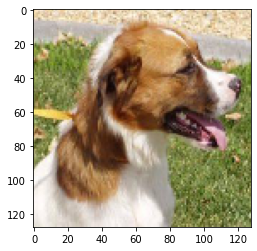

Pred value = [[1.]]
This image has a DOG


In [19]:
real_pred(cnn_Model)

# Applying Transfer Learning.
Transfer learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.
Here i will be using VGG16 for Transfer learning.\
Read more about VGG16 [Here](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/)

In [20]:
#importing VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [21]:
#configuring VGG16 model
vgg_model = VGG16(input_shape = (128,128,3), 
                  weights = 'imagenet',
                  include_top = False)

58900480/58889256 [==============================] - 0s 0us/step


In [22]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [23]:
# now before inserting final layers, all other layers should be set to non-trainable as its been already trained.
for layer in vgg_model.layers:
    layer.trainable = False

In [24]:
#Now lets flatten the last layer and input add final layers
x=Flatten()(vgg_model.output) #Flattening
x=Dropout(0.33)(x)
#x=Dense(4096, activation='relu')(x) #Dense layer
x=Dense(1, activation = 'sigmoid')(x) #Final layer

cnn_Model2=Model(vgg_model.input, x)   #Final Model

cnn_Model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Compiling and training the VGG model with callbacks

In [25]:
checkpoint = ModelCheckpoint('cvd_cnn_model_vgg16.h5',monitor = 'val_accuracy', verbose = 1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose = 1, mode = 'max')

callbacks_list = [checkpoint, earlystop]

In [26]:
#Compiling
cnn_Model2.compile(optimizer = tf.keras.optimizers.Adam() , loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
#Training
history2 = cnn_Model2.fit(train_data, steps_per_epoch=train_data.samples//batch_size, 
                                    validation_data=val_data, validation_steps=val_data.samples//batch_size,
                                    epochs=25, verbose=1, shuffle=True,  callbacks=callbacks_list)

Epoch 1/25
46/46 [==============================] - 56s 1s/step - loss: 0.5903 - accuracy: 0.6823 - val_loss: 0.4532 - val_accuracy: 0.7870

Epoch 00001: val_accuracy improved from -inf to 0.78698, saving model to cvd_cnn_model_vgg16.h5
Epoch 2/25
46/46 [==============================] - 51s 1s/step - loss: 0.4346 - accuracy: 0.7980 - val_loss: 0.3869 - val_accuracy: 0.8271

Epoch 00002: val_accuracy improved from 0.78698 to 0.82708, saving model to cvd_cnn_model_vgg16.h5
Epoch 3/25
46/46 [==============================] - 51s 1s/step - loss: 0.4003 - accuracy: 0.8154 - val_loss: 0.3724 - val_accuracy: 0.8427

Epoch 00003: val_accuracy improved from 0.82708 to 0.84271, saving model to cvd_cnn_model_vgg16.h5
Epoch 4/25
46/46 [==============================] - 51s 1s/step - loss: 0.3794 - accuracy: 0.8244 - val_loss: 0.3574 - val_accuracy: 0.8531

Epoch 00004: val_accuracy improved from 0.84271 to 0.85312, saving model to cvd_cnn_model_vgg16.h5
Epoch 5/25
46/46 [=========================

## Plotting Accuracies and Losses, Evaluating and Final Predicting.

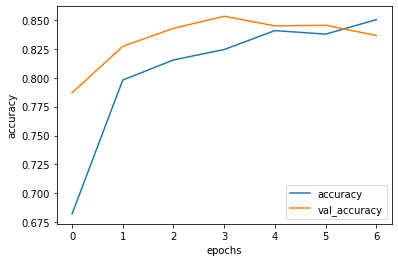

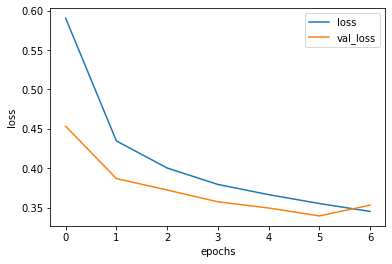

In [28]:
#Plotting losses and accuracies after training
plot_acc_los(history2)

In [29]:
# Evaluating model accuracy and loss on test data
los, acc = cnn_Model2.evaluate(test_data)
print("accuracy = ", acc*100, "%, Loss = ", los*100, "%")

2023/2023 [==============================] - 12s 6ms/step - loss: 0.3118 - accuracy: 0.8680
accuracy =  86.80177927017212 %, Loss =  31.175023317337036 %


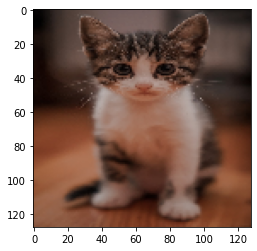

Pred value = [[0.]]
This image has a CAT


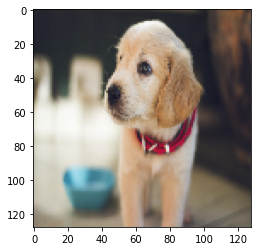

Pred value = [[1.]]
This image has a DOG


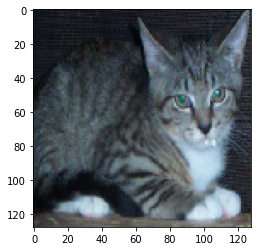

Pred value = [[0.]]
This image has a CAT


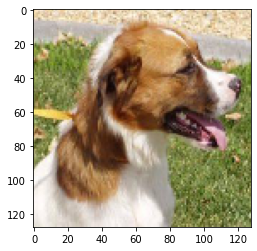

Pred value = [[1.]]
This image has a DOG


In [30]:
# Predicting using the test images
real_pred(cnn_Model2)

In [31]:
#To manually predict the images uncomment the below 2 lines
#test= 'replace_this_with_image_location'
#predict_img(cnn_Model2, test)

# Conclusion

- In this notebook, I have built two models one from scratch and another one using transfer learning (vgg16) to classify an image as a cat or a dog.
- The first model gave an accuracy of around 81% in around 23 minutes and 26 epochs. 
- The second model gave an accuracy of 87% in just 7 epochs and the training time was around 7 minutes. 
- So if one is hardware limited then the transfer learning is the life saviour.

# Thankyou for Having a look over my work.
#### View my other works in my [GitHub](https://github.com/bash-sanka1p)
#### Connect with me on [LinkedIn](https://www.linkedin.com/in/bash-sanka1p/)
#### Contact Email : [chiku.bais11022002@gmail.com](mailto:chiku.bais11022002@gmail.com)